<a href="https://colab.research.google.com/github/amylokh/Brain-MRI-Classification/blob/master/Generating%20brain%20MRI%20using%20GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import tensorflow as tf

In [66]:
tf.__version__

'2.12.0'

In [67]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-m026yt8f
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-m026yt8f
  Resolved https://github.com/tensorflow/docs to commit 77b51f822f16a7527a0159b8ec3683759aa229d3
  Preparing metadata (setup.py) ... done


In [68]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import PIL
from tensorflow.keras import layers
from tqdm import tqdm
import time

from IPython import display

In [69]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [70]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 28

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Dataset/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img,(image_size, image_size))
        img = np.float32(img)
      # Normalize pixel values to be between 0 and 1
        img /= 255.0
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Dataset/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img,(image_size, image_size))
        img = np.float32(img)
      # Normalize pixel values to be between 0 and 1
        img /= 255.0
        X_test.append(img)
        y_test.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 78/78 [00:03<00:00, 25.94it/s]


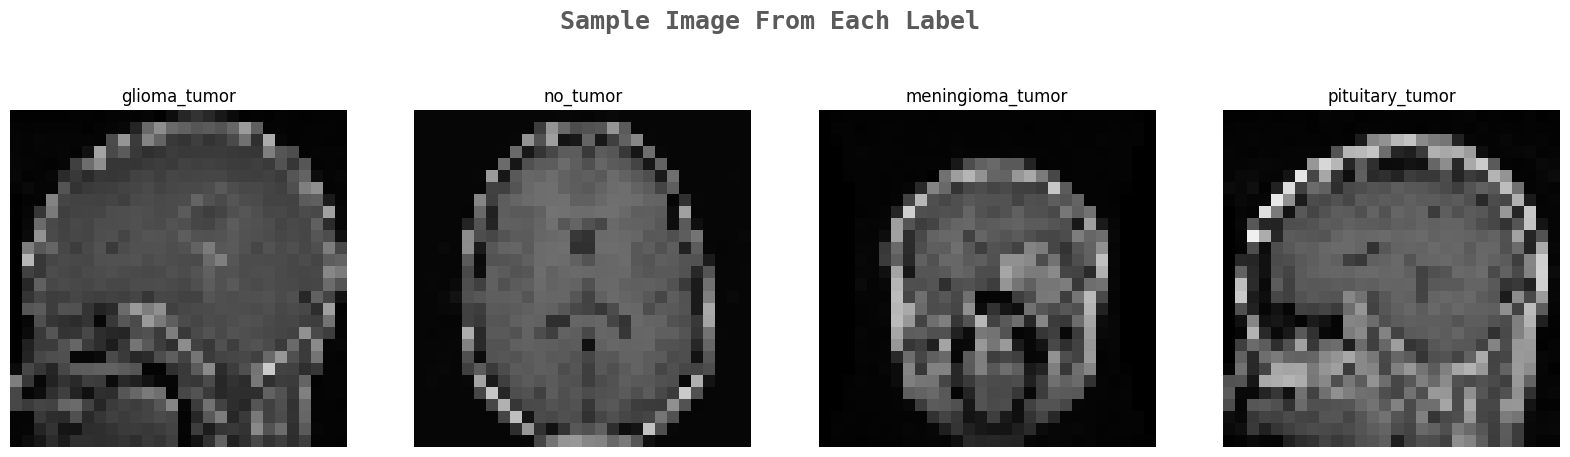

In [71]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

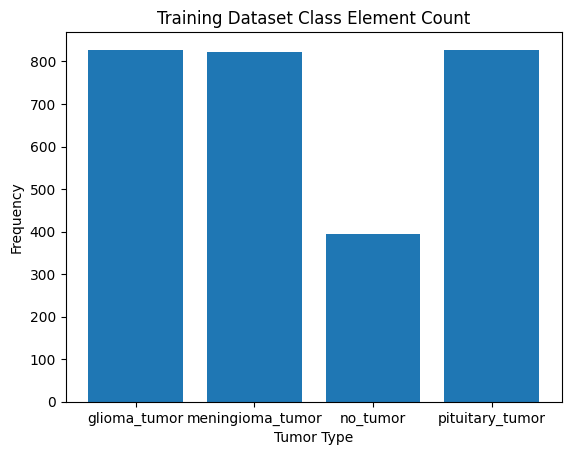

In [72]:
def count_element_frequency(arr):
    unique_values, counts = np.unique(arr, return_counts=True)
    frequencies = dict(zip(unique_values, counts))
    return frequencies

element_frequencies = count_element_frequency(y_train)

# Plotting the bar graph
plt.bar(element_frequencies.keys(), element_frequencies.values())
plt.xlabel('Tumor Type')
plt.ylabel('Frequency')
plt.title('Training Dataset Class Element Count')

# Force display all tick labels on x-axis
plt.xticks(list(element_frequencies.keys()))

plt.show()


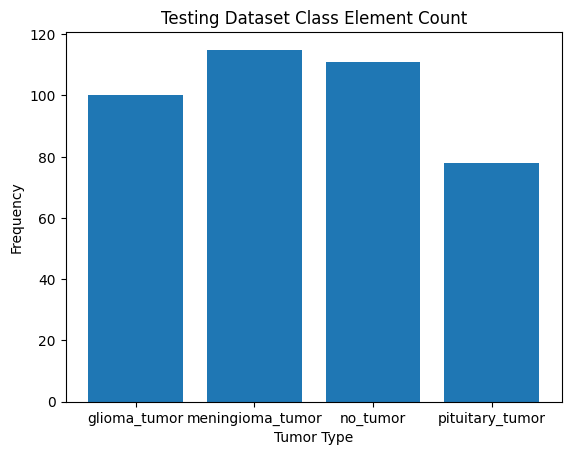

In [73]:
test_element_frequencies = count_element_frequency(y_test)

# Plotting the bar graph
plt.bar(test_element_frequencies.keys(), test_element_frequencies.values())
plt.xlabel('Tumor Type')
plt.ylabel('Frequency')
plt.title('Testing Dataset Class Element Count')

# Force display all tick labels on x-axis
plt.xticks(list(test_element_frequencies.keys()))

plt.show()

In [94]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 256

In [95]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [96]:
print(len(X_train))

2872


In [97]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

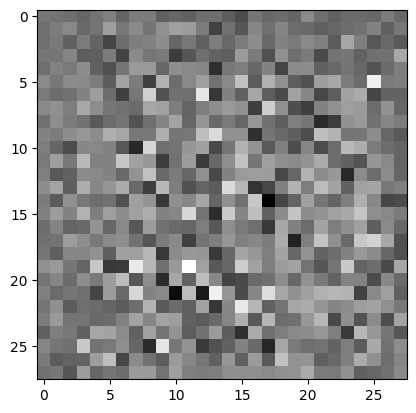

In [98]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [99]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [100]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00055058]], shape=(1, 1), dtype=float32)


In [101]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [103]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [102]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [104]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [105]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [106]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [107]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [109]:
from PIL import Image
def save_images_to_local_drive(predictions, epoch):
    if epoch > 0:
      directory = '/content/drive/MyDrive/Generated MRIs using GANs'
      # if not os.path.exists(directory):
      #   os.makedirs(directory)

      predictions = predictions.numpy()
      for i in range(predictions.shape[0]):
        image_data = predictions[i].reshape((28, 28))
        # Extract the image data for each image
        image_data = (image_data * 255).astype(np.uint8)

        # Create a PIL Image object from the image data
        image = Image.fromarray(image_data)

        # Save the image to a file in PNG format
        image.save(f"/content/drive/MyDrive/Generated MRIs using GANs/image_epoch_{epoch}_no. {i}.png", format="PNG")

In [108]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  save_images_to_local_drive(predictions, epoch)

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [110]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [111]:
train(train_dataset, EPOCHS)

ValueError: ignored

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))